# Prédiction de résultats en Formule 1

Ce notebook construit un modèle inspiré de l'analyse Kaggle (lien donné) pour prédire des résultats de courses F1.

Objectifs :
- Charger toutes les tables CSV dans `data/`
- Assembler un jeu de features sans fuite de données (avant chaque course)
- Entraîner et évaluer un modèle (classification binaire: marquer des points vs non)
- Option: sauvegarder le modèle

In [16]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
DATA_DIR = Path('data')
pd.set_option('mode.copy_on_write', True)

In [17]:
# Chargement des données
circuits = pd.read_csv(DATA_DIR / 'circuits.csv')
constructors = pd.read_csv(DATA_DIR / 'constructors.csv')
constructor_results = pd.read_csv(DATA_DIR / 'constructor_results.csv')
constructor_standings = pd.read_csv(DATA_DIR / 'constructor_standings.csv')
drivers = pd.read_csv(DATA_DIR / 'drivers.csv')
driver_standings = pd.read_csv(DATA_DIR / 'driver_standings.csv')
lap_times = pd.read_csv(DATA_DIR / 'lap_times.csv')
pit_stops = pd.read_csv(DATA_DIR / 'pit_stops.csv')
qualifying = pd.read_csv(DATA_DIR / 'qualifying.csv')
races = pd.read_csv(DATA_DIR / 'races.csv')
results = pd.read_csv(DATA_DIR / 'results.csv')
seasons = pd.read_csv(DATA_DIR / 'seasons.csv')
sprint_results = pd.read_csv(DATA_DIR / 'sprint_results.csv')
status = pd.read_csv(DATA_DIR / 'status.csv')

# Types de base
races['date'] = pd.to_datetime(races['date'], errors='coerce')
drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')
qualifying['position'] = pd.to_numeric(qualifying['position'], errors='coerce')
results['grid'] = pd.to_numeric(results['grid'], errors='coerce')
results['position'] = pd.to_numeric(results['position'], errors='coerce')
results['points'] = pd.to_numeric(results['points'], errors='coerce')
results['rank'] = pd.to_numeric(results['rank'], errors='coerce')

In [18]:
# Assemblage base: results + races + drivers + constructors + circuits
base = results.merge(races[['raceId','year','round','circuitId','date','name']].rename(columns={'name':'race_name'}), on='raceId', how='left')
base = base.merge(drivers[['driverId','driverRef','code','dob','nationality']].rename(columns={'code':'driver_code'}), on='driverId', how='left')
base = base.merge(constructors[['constructorId','name','nationality']].rename(columns={'name':'constructor_name','nationality':'constructor_nat'}), on='constructorId', how='left')
base = base.merge(circuits[['circuitId','name','country']].rename(columns={'name':'circuit_name','country':'circuit_country'}), on='circuitId', how='left')
# Ajout meilleure position de qualif (Q pos min) par driver-race
qpos = qualifying.groupby(['raceId','driverId'], as_index=False)['position'].min().rename(columns={'position':'q_position'})
base = base.merge(qpos, on=['raceId','driverId'], how='left')
# Sprint points avant course (pas fuite si le sprint est le même weekend? On considère que sprint précède la course principale)
sprint_pts = sprint_results.groupby(['raceId','driverId'], as_index=False)['points'].sum().rename(columns={'points':'sprint_points'})
base = base.merge(sprint_pts, on=['raceId','driverId'], how='left')
base['sprint_points'] = base['sprint_points'].fillna(0.0)

# Cible: a-t-il marqué des points à la course principale ?
base['target_points_scored'] = (base['points'] > 0).astype(int)
# On retirera les features issues du résultat final lors du fit.
base.shape

(26519, 34)

In [19]:
# Features cumulatives pré-course (sans fuite):
# On trie par (driver, date) et on calcule cumuls avant la course courante.
base = base.sort_values(['driverId','date'])
group = base.groupby('driverId', group_keys=False)
base['driver_prev_races'] = group.cumcount()
base['driver_cum_points'] = group['points'].apply(lambda s: s.shift(1).cumsum())
base['driver_cum_wins'] = group['position'].apply(lambda s: (s.eq(1).shift(1)).cumsum())
base['driver_last_grid'] = group['grid'].shift(1)
base['driver_avg_grid_5'] = group['grid'].apply(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
base['driver_avg_points_5'] = group['points'].apply(lambda s: s.shift(1).rolling(5, min_periods=1).mean())

# Analogues pour écurie
base = base.sort_values(['constructorId','date'])
cgroup = base.groupby('constructorId', group_keys=False)
base['team_prev_races'] = cgroup.cumcount()
base['team_cum_points'] = cgroup['points'].apply(lambda s: s.shift(1).cumsum())
base['team_avg_points_5'] = cgroup['points'].apply(lambda s: s.shift(1).rolling(5, min_periods=1).mean())

# Âge du pilote au jour de la course
base['driver_age'] = (base['date'] - base['dob']).dt.days / 365.25

# Historique sur ce circuit pour le pilote (avant course)
base = base.sort_values(['driverId','circuitId','date'])
dcg = base.groupby(['driverId','circuitId'], group_keys=False)
base['driver_circuit_prev'] = dcg.cumcount()
base['driver_circuit_best_pos'] = dcg['position'].apply(lambda s: s.shift(1).cummin())

# Nettoyage NaN résultant des shifts
for col in ['driver_cum_points','driver_cum_wins','driver_last_grid','driver_avg_grid_5','driver_avg_points_5',
            'team_cum_points','team_avg_points_5','driver_age','driver_circuit_prev','driver_circuit_best_pos']:
    base[col] = base[col].fillna(0)

# Grid de qualification: on préfère q_position si dispo, sinon grid officiel
base['grid_feature'] = base['q_position'].fillna(base['grid'])
base['grid_feature'] = base['grid_feature'].fillna(base['grid_feature'].median())

# Colonnes catégorielles
base['season'] = base['year'].astype(int)
base['round'] = base['round'].astype(int)
cat_cols = ['constructor_name','constructor_nat','circuit_name','circuit_country','driver_nat']
base['driver_nat'] = base['nationality']
# Jeu final de features
feature_cols = [
    'grid_feature','sprint_points','driver_prev_races','driver_cum_points','driver_cum_wins',
    'driver_last_grid','driver_avg_grid_5','driver_avg_points_5','team_prev_races','team_cum_points',
    'team_avg_points_5','driver_age','driver_circuit_prev','driver_circuit_best_pos','season','round'
] + cat_cols
target_col = 'target_points_scored'
df_model = base.dropna(subset=['date']).copy()
df_model = df_model[feature_cols + [target_col, 'date']]
df_model.shape

/var/folders/h8/79c6rr5j4c11m97jk5x3dr7c0000gn/T/ipykernel_5623/1451080877.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base[col] = base[col].fillna(0)


(26519, 23)

In [20]:
# Inspection rapide du fichier météo (weather_features_v4.parquet)
from pathlib import Path
import pandas as pd
import numpy as np

wx_path = DATA_DIR / 'weather_features_v4.parquet'
if wx_path.exists():
    try:
        w0 = pd.read_parquet(wx_path)
        print('weather_features_v4.parquet chargé. Lignes:', len(w0))
        print('Colonnes:', list(w0.columns))
        print('DTypes:')
        print(w0.dtypes)
        # Chercher une colonne date potentielle
        cols_lower = {c.lower(): c for c in w0.columns}
        aliases = ['date','datetime','time','dt','ds','day','valid','timestamp','valid_time_gmt']
        found = [cols_lower[a] for a in aliases if a in cols_lower]
        if found:
            cand = found[0]
            s = w0[cand]
            if np.issubdtype(s.dtype, np.number):
                # Heuristique epoch
                sdt = pd.to_datetime(s, unit='ms', errors='coerce')
                if sdt.notna().mean() < 0.5:
                    sdt = pd.to_datetime(s, unit='s', errors='coerce')
            else:
                sdt = pd.to_datetime(s, errors='coerce')
            print('Colonne date candidate:', cand, 'min=', sdt.min(), 'max=', sdt.max())
        else:
            # Essayer year/month/day
            y = None
            for a in ['year','yr','annee']:
                if a in cols_lower: y = cols_lower[a]; break
            m = None
            for a in ['month','mo','mn','mois']:
                if a in cols_lower: m = cols_lower[a]; break
            d = None
            for a in ['day','dy','dom','dayofmonth','jour']:
                if a in cols_lower: d = cols_lower[a]; break
            if y and m and d:
                sdt = pd.to_datetime(dict(year=w0[y], month=w0[m], day=w0[d]), errors='coerce')
                print('Colonnes Y/M/D détectées:', (y,m,d), 'min=', sdt.min(), 'max=', sdt.max())
            else:
                print("Aucune colonne de date évidente trouvée. Fournissez les noms si besoin.")
        # Aperçu compact
        display(w0.head(3))
    except Exception as ex:
        print('Lecture weather_features_v4.parquet impossible:', ex)
        print('Si le message concerne pyarrow, je peux l’installer automatiquement.')
else:
    print('Fichier weather_features_v4.parquet introuvable dans', wx_path)

weather_features_v4.parquet chargé. Lignes: 1125
Colonnes: ['temperature', 'precipitation', 'windspeed', 'round', 'name', 'datetime']
DTypes:
temperature             float64
precipitation           float64
windspeed               float64
round                     int64
name                     object
datetime         datetime64[ns]
dtype: object
Colonne date candidate: datetime min= 1950-05-13 12:00:00 max= 2024-12-08 13:00:00


,temperature,precipitation,windspeed,round,name,datetime
0,15.8,0.0,18.8,1,British Grand Prix,1950-05-13 12:00:00
1,23.1,0.0,17.3,2,Monaco Grand Prix,1950-05-21 12:00:00
2,19.5,0.2,12.5,3,Indianapolis 500,1950-05-30 14:00:00


In [21]:
# (Optionnel) Mapping manuel des colonnes météo
# Si vos colonnes ne sont pas reconnues automatiquement, renseignez ici les noms exacts pour weather_features_v4.parquet.
# Laissez None si inconnu/inexistant. Exemple et clés supportées:
#   - Dates: soit une colonne unique 'date' (texte/epoch), soit triplet year/month/day
#   - epoch_unit: 's' | 'ms' si 'date' est numérique epoch
#   - Localisation: city, country, lat, lon (au moins une paire utile: lat/lon ou city/country)
#   - Mesures: temp, humidity, wind, precip, desc
#   - Identifiants: raceid (si la météo porte cet ID), circuitid (au besoin)
#
WEATHER_MANUAL_MAP = {
    'date': None,             # ex: 'timestamp' ou 'valid_time_gmt'
    'year': None,            # ex: 'yr'
    'month': None,           # ex: 'mo'
    'day': None,             # ex: 'dy'
    'epoch_unit': None,      # 's' ou 'ms'
    'city': None,            # ex: 'ville'
    'country': None,         # ex: 'pays'
    'lat': None,             # ex: 'latitude'
    'lon': None,             # ex: 'longitude'
    'temp': None,            # ex: 'tmean'
    'humidity': None,        # ex: 'rh'
    'wind': None,            # ex: 'wind_spd'
    'precip': None,          # ex: 'prcp'
    'desc': None,            # ex: 'conditions'
    'raceid': None,          # ex: 'raceId' si présent
    'circuitid': None        # ex: 'circuitId' si présent
}
print('WEATHER_MANUAL_MAP prêt. Modifiez ce dict si besoin.')

WEATHER_MANUAL_MAP prêt. Modifiez ce dict si besoin.


In [22]:
# Features additionnelles issues des autres tables (sans fuite) + Météo

# 0) Intégration météo (weather_features_v4.parquet)
try:
    w = pd.read_parquet(DATA_DIR / 'weather_features_v4.parquet')

    # -------- Normalisation colonnes + utilitaires --------
    import unicodedata
    def normalize_name(s):
        s = unicodedata.normalize('NFKD', str(s)).encode('ascii', 'ignore').decode('utf-8')
        s = s.strip().lower().replace('\n',' ').replace('\r',' ')
        for ch in [' ', '-', '.', '/', '\\', '(', ')', '[', ']', '{', '}', ':', ';', ',']:
            s = s.replace(ch, '_')
        while '__' in s:
            s = s.replace('__','_')
        return s.strip('_')

    norm_to_orig = {normalize_name(c): c for c in w.columns}
    def pick(*candidates):
        for cand in candidates:
            if cand in norm_to_orig:
                return norm_to_orig[cand]
        return None

    # Appliquer les mappings manuels si renseignés
    mm = WEATHER_MANUAL_MAP if 'WEATHER_MANUAL_MAP' in globals() else {}
    def mapped(key, *fallbacks):
        # priorité mapping manuel, puis alias pick
        v = mm.get(key) if isinstance(mm, dict) else None
        if v:
            return v
        for fb in fallbacks:
            c = pick(fb)
            if c is not None:
                return c
        return None

    # Heuristique: trouver une colonne date si alias/mapping ne marchent pas
    def detect_date_column(df):
        # 1) mapping manuel direct
        if mapped('date'):
            return mapped('date'), None
        if mapped('year') and mapped('month') and mapped('day'):
            return None, (mapped('year'), mapped('month'), mapped('day'))
        # 2) alias courants
        for key in [
            'date','datetime','time','dt','ds','day','valid','timestamp','valid_time_gmt',
            'date_utc','date_local','datetime_utc','datetime_local','time_utc','time_local'
        ]:
            c = pick(key)
            if c is not None:
                return c, None  # direct
        # 3) Y/M/D par alias
        y = pick('year','yr','annee','yyyy')
        m = pick('month','mo','mn','mois','mm')
        d = pick('day','dy','dom','dayofmonth','jour','dd')
        if y and m and d:
            return None, (y,m,d)
        # 4) scan heuristique: tester toutes colonnes
        best = (None, 0.0, None)  # (col, score, unit)
        for c in w.columns:
            s = w[c]
            try:
                score = 0
                unit = None
                if np.issubdtype(s.dtype, np.number):
                    for u in ['s','ms','us','ns']:
                        dt = pd.to_datetime(s, unit=u, errors='coerce')
                        ratio = dt.notna().mean()
                        if ratio > score:
                            score = ratio; unit = u
                else:
                    dt = pd.to_datetime(s, errors='coerce')
                    score = dt.notna().mean(); unit = None
                if score >= 0.7:
                    return c, unit
            except Exception:
                continue
        return None, None

    date_col = None
    ymd = None
    date_unit = None
    dcol, ymd = detect_date_column(w)
    if dcol is not None:
        date_col = dcol
    date_unit = mm.get('epoch_unit') if isinstance(mm, dict) else None

    # Autres colonnes cibles (détection par alias + mapping)
    def find_by_keywords(keys, prefer_numeric=None, map_key=None):
        # mapping manuel prioritaire
        if map_key and isinstance(mm, dict) and mm.get(map_key):
            return mm.get(map_key)
        # alias exacts
        for k in keys:
            c = pick(k)
            if c is not None:
                return c
        # substring
        for k in keys:
            for n, o in norm_to_orig.items():
                if k in n:
                    if prefer_numeric is None:
                        return o
                    is_num = np.issubdtype(w[o].dtype, np.number)
                    if prefer_numeric and is_num:
                        return o
                    if (prefer_numeric is False) and (not is_num):
                        return o
        return None

    city_col = find_by_keywords(['city','location','name','ville','lieu'], prefer_numeric=False, map_key='city')
    country_col = find_by_keywords(['country','nation','state','pays'], prefer_numeric=False, map_key='country')
    lat_col = find_by_keywords(['lat','latitude','y'], prefer_numeric=True, map_key='lat')
    lon_col = find_by_keywords(['lon','lng','longitude','x'], prefer_numeric=True, map_key='lon')
    temp_col = find_by_keywords(['temp','temperature','tavg','tmean','temp_mean_c','air_temp'], prefer_numeric=True, map_key='temp')
    hum_col = find_by_keywords(['humidity','rh','humid','humidity_mean','relhum'], prefer_numeric=True, map_key='humidity')
    wind_col = find_by_keywords(['wind','wind_speed','windspeed','wind_spd','wind_avg'], prefer_numeric=True, map_key='wind')
    precip_col = find_by_keywords(['precip','precipitation','rain','prcp','precip_mm','precipitation_mm'], prefer_numeric=True, map_key='precip')
    desc_col = find_by_keywords(['weather','conditions','description','summary','wx_phrase','meteo','meteo_desc'], prefer_numeric=False, map_key='desc')
    rid_col = mapped('raceid', 'raceid', 'race_id')
    cid_col = mapped('circuitid', 'circuitid', 'circuit_id')

    # Détection lat/lon par gamme si manquants
    if lat_col is None or lon_col is None:
        num_cols = [c for c in w.columns if np.issubdtype(w[c].dtype, np.number)]
        lat_guess, lon_guess = None, None
        for c in num_cols:
            s = pd.to_numeric(w[c], errors='coerce')
            if s.between(-90,90).mean() > 0.9 and lat_guess is None:
                lat_guess = c
            if s.between(-180,180).mean() > 0.9 and lon_guess is None:
                lon_guess = c
        if lat_col is None and lat_guess is not None:
            lat_col = lat_guess
        if lon_col is None and lon_guess is not None:
            lon_col = lon_guess

    # -------- Construction DF météo standardisé --------
    ww = w.copy()
    # Date
    if date_col is not None:
        s = ww[date_col]
        if date_unit is not None and np.issubdtype(s.dtype, np.number):
            sdt = pd.to_datetime(s, unit=date_unit, errors='coerce')
        elif np.issubdtype(s.dtype, np.number):
            sdt = pd.to_datetime(s, unit='ms', errors='coerce')
            if sdt.notna().mean() < 0.5:
                sdt = pd.to_datetime(s, unit='s', errors='coerce')
        else:
            sdt = pd.to_datetime(s, errors='coerce')
        ww['wx_date'] = sdt.dt.date
    elif ymd is not None:
        y, m, d = ymd
        ww['wx_date'] = pd.to_datetime(dict(year=ww[y], month=ww[m], day=ww[d]), errors='coerce').dt.date
    else:
        ww['wx_date'] = pd.NaT

    # Coord/location + identifiants
    ww['wx_lat'] = pd.to_numeric(ww[lat_col], errors='coerce') if lat_col else np.nan
    ww['wx_lon'] = pd.to_numeric(ww[lon_col], errors='coerce') if lon_col else np.nan
    ww['wx_city'] = ww[city_col].astype(str) if city_col else ''
    ww['wx_country'] = ww[country_col].astype(str) if country_col else ''
    if temp_col: ww['wx_temp'] = pd.to_numeric(ww[temp_col], errors='coerce')
    if hum_col: ww['wx_humidity'] = pd.to_numeric(ww[hum_col], errors='coerce')
    if wind_col: ww['wx_wind'] = pd.to_numeric(ww[wind_col], errors='coerce')
    if precip_col: ww['wx_precip'] = pd.to_numeric(ww[precip_col], errors='coerce')
    if desc_col: ww['wx_desc'] = ww[desc_col].astype(str)
    if rid_col and rid_col in ww.columns: ww['wx_raceid'] = ww[rid_col]
    if cid_col and cid_col in ww.columns: ww['wx_circuitid'] = ww[cid_col]

    # Aggrégation quotidienne par localisation/ids (si granularité horaire)
    group_keys = []
    if 'wx_date' in ww.columns and pd.Series(ww['wx_date']).notna().any():
        group_keys = ['wx_date']
    key_pref = False
    if 'wx_raceid' in ww.columns:
        group_keys = ['wx_raceid'] + group_keys
        key_pref = True
    elif 'wx_circuitid' in ww.columns:
        group_keys = ['wx_circuitid'] + group_keys
        key_pref = True
    if lat_col and lon_col and not key_pref:
        group_keys += ['wx_lat','wx_lon']
    elif (city_col or country_col) and not key_pref:
        group_keys += ['wx_city','wx_country']

    present_measures = [c for c in ['wx_temp','wx_humidity','wx_wind','wx_precip','wx_desc'] if c in ww.columns]
    if group_keys:
        if present_measures:
            agg_map = {}
            if 'wx_temp' in present_measures: agg_map['wx_temp'] = 'mean'
            if 'wx_humidity' in present_measures: agg_map['wx_humidity'] = 'mean'
            if 'wx_wind' in present_measures: agg_map['wx_wind'] = 'mean'
            if 'wx_precip' in present_measures: agg_map['wx_precip'] = 'sum'
            if 'wx_desc' in present_measures: agg_map['wx_desc'] = 'first'
            wagg = ww.groupby(group_keys, as_index=False).agg(agg_map)
        else:
            wagg = ww[group_keys].drop_duplicates().copy()
    else:
        wagg = ww.copy()

    # Préparer base pour jointure
    if 'circuit_location' not in base.columns:
        base = base.merge(circuits[['circuitId','location']].rename(columns={'location':'circuit_location'}),
                          on='circuitId', how='left')
    base['race_date'] = base['date'].dt.date

    def norm_text_series(s):
        return (s.fillna('')
                  .astype(str)
                  .apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8'))
                  .str.lower()
                  .str.strip())

    race_wx = base.copy()

    # A) Jointure directe par raceId si présent
    if 'wx_raceid' in wagg.columns:
        num_cols_agg = [c for c in ['wx_temp','wx_humidity','wx_wind','wx_precip'] if c in wagg.columns]
        agg_map = {c: 'mean' for c in num_cols_agg}
        if 'wx_desc' in wagg.columns: agg_map['wx_desc'] = 'first'
        w_rid = wagg.groupby('wx_raceid', as_index=False).agg(agg_map) if num_cols_agg else wagg.drop_duplicates(['wx_raceid'])
        race_wx = race_wx.merge(w_rid, left_on='raceId', right_on='wx_raceid', how='left')
    # B) Jointure directe par circuitId
    elif 'wx_circuitid' in wagg.columns:
        if 'wx_date' in wagg.columns:
            race_wx = race_wx.merge(wagg.rename(columns={'wx_circuitid':'circuitId','wx_date':'race_date'}),
                                    on=['circuitId','race_date'], how='left', suffixes=('','_wx'))
        else:
            w_cid = wagg.groupby('wx_circuitid', as_index=False).agg({
                k: ('sum' if k=='wx_precip' else 'mean') for k in present_measures if k in wagg.columns
            }) if 'wx_circuitid' in wagg.columns else wagg.copy()
            race_wx = race_wx.merge(w_cid.rename(columns={'wx_circuitid':'circuitId'}), on='circuitId', how='left')
    else:
        # C) Ville+pays
        if ('wx_city' in wagg.columns and 'wx_country' in wagg.columns and
            'circuit_location' in race_wx.columns and 'circuit_country' in race_wx.columns):
            wagg['loc_key'] = norm_text_series(wagg['wx_city']) + '|' + norm_text_series(wagg['wx_country'])
            race_wx['loc_key'] = norm_text_series(race_wx['circuit_location']) + '|' + norm_text_series(race_wx['circuit_country'])
            if 'wx_date' in wagg.columns:
                race_wx = race_wx.merge(
                    wagg.rename(columns={'wx_date':'race_date'}),
                    on=['race_date','loc_key'], how='left', suffixes=('','_wx')
)
            else:
                wagg2 = wagg.groupby(['loc_key'], as_index=False).agg({
                    k: ('sum' if k=='wx_precip' else 'mean') for k in present_measures if k in wagg.columns
                }) if 'loc_key' in wagg.columns else wagg.copy()
                race_wx = race_wx.merge(wagg2, on=['loc_key'], how='left')
        # D) Fallback lat/lon arrondis
        need_fill = race_wx['wx_temp'].isna() if 'wx_temp' in race_wx.columns else pd.Series(True, index=race_wx.index)
        if need_fill.any() and ('wx_lat' in wagg.columns and 'wx_lon' in wagg.columns and 'lat' in circuits.columns and 'lng' in circuits.columns):
            circ = circuits[['circuitId','lat','lng']].rename(columns={'lat':'c_lat','lng':'c_lon'}).copy()
            circ['c_lat_r'] = circ['c_lat'].round(1)
            circ['c_lon_r'] = circ['c_lon'].round(1)
            w2 = wagg.dropna(subset=['wx_lat','wx_lon']).copy()
            w2['wx_lat_r'] = w2['wx_lat'].round(1)
            w2['wx_lon_r'] = w2['wx_lon'].round(1)
            race_wx2 = base.merge(circ, on='circuitId', how='left')
            race_wx2['race_date'] = race_wx2['date'].dt.date
            if 'wx_date' in w2.columns:
                race_wx2 = race_wx2.merge(w2.rename(columns={'wx_date':'race_date'}),
                                          left_on=['race_date','c_lat_r','c_lon_r'],
                                          right_on=['race_date','wx_lat_r','wx_lon_r'], how='left')
            else:
                race_wx2 = race_wx2.merge(w2.drop(columns=['wx_lat','wx_lon'], errors='ignore'),
                                          left_on=['c_lat_r','c_lon_r'],
                                          right_on=['wx_lat_r','wx_lon_r'], how='left')
            for col in ['wx_temp','wx_humidity','wx_wind','wx_precip','wx_desc','wx_lat','wx_lon']:
                if col in race_wx2.columns:
                    if col not in race_wx.columns:
                        race_wx[col] = np.nan
                    race_wx.loc[race_wx[col].isna(), col] = race_wx2.loc[race_wx[col].isna(), col]
        # E) Fallback pays seul
        if ('wx_country' in wagg.columns) and ('circuit_country' in race_wx.columns):
            need_fill = race_wx['wx_temp'].isna() if 'wx_temp' in race_wx.columns else pd.Series(True, index=race_wx.index)
            if need_fill.any():
                w3 = wagg.copy()
                w3['country_key'] = norm_text_series(w3['wx_country'])
                race_wx['country_key'] = norm_text_series(race_wx['circuit_country'])
                if 'wx_date' in w3.columns:
                    w3c = w3.groupby(['wx_date','country_key'], as_index=False).agg({
                        k: ('sum' if k=='wx_precip' else 'mean') for k in present_measures if k in w3.columns
                    }).rename(columns={'wx_date':'race_date'})
                    race_wx = race_wx.merge(w3c, on=['race_date','country_key'], how='left', suffixes=('','_ctry'))
                else:
                    w3c = w3.groupby(['country_key'], as_index=False).agg({
                        k: ('sum' if k=='wx_precip' else 'mean') for k in present_measures if k in w3.columns
                    })
                    race_wx = race_wx.merge(w3c, on=['country_key'], how='left', suffixes=('','_ctry'))
                for col in ['wx_temp','wx_humidity','wx_wind','wx_precip']:
                    src = col+'_ctry'
                    if src in race_wx.columns:
                        if col not in race_wx.columns: race_wx[col] = np.nan
                        race_wx[col] = race_wx[col].fillna(race_wx[src])
                drop_ctry = [c for c in race_wx.columns if c.endswith('_ctry')]
                if drop_ctry:
                    race_wx = race_wx.drop(columns=drop_ctry)

    if 'wx_precip' in race_wx.columns:
        race_wx['wx_rain_flag'] = (race_wx['wx_precip'].fillna(0) > 0.1).astype(int)
        race_wx['wx_heavy_rain'] = (race_wx['wx_precip'].fillna(0) > 5.0).astype(int)
    else:
        race_wx['wx_rain_flag'] = 0
        race_wx['wx_heavy_rain'] = 0

    # Stat de couverture
    wx_cov = race_wx['wx_temp'].notna().mean() if 'wx_temp' in race_wx.columns else 0.0
    print(f'Couverture météo sur courses: {wx_cov:.1%}')

    base = race_wx
except Exception as e:
    print('Weather integration skipped:', e)

# 1) Lap times: meilleur tour par course, puis moyenne roulante précédente
# Idempotence: supprimer anciennes colonnes si elles existent avant fusion
for col in ['driver_prev_best_lap_ms','driver_roll_bestlap5']:
    if col in base.columns:
        base = base.drop(columns=[col])
lap_best = lap_times.groupby(['raceId', 'driverId'], as_index=False)['milliseconds'].min()
lap_best = lap_best.rename(columns={'milliseconds': 'best_lap_ms'})
lap_best = lap_best.merge(races[['raceId', 'date']], on='raceId', how='left')
lap_best = lap_best.sort_values(['driverId', 'date'])
lg = lap_best.groupby('driverId', group_keys=False)
lap_best['driver_prev_best_lap_ms'] = lg['best_lap_ms'].shift(1)
lap_best['driver_roll_bestlap5'] = lg['best_lap_ms'].shift(1).rolling(5, min_periods=1).mean()
base = base.merge(lap_best[['raceId','driverId','driver_prev_best_lap_ms','driver_roll_bestlap5']],
                  on=['raceId','driverId'], how='left')

# 2) Pit stops: idempotence
for col in ['driver_prev_pit_count','driver_roll_pit5']:
    if col in base.columns:
        base = base.drop(columns=[col])
pit_counts = pit_stops.groupby(['raceId','driverId']).size().reset_index(name='pit_count')
pit_counts = pit_counts.merge(races[['raceId','date']], on='raceId', how='left')
pit_counts = pit_counts.sort_values(['driverId','date'])
pg = pit_counts.groupby('driverId', group_keys=False)
pit_counts['driver_prev_pit_count'] = pg['pit_count'].shift(1)
pit_counts['driver_roll_pit5'] = pg['pit_count'].shift(1).rolling(5, min_periods=1).mean()
base = base.merge(pit_counts[['raceId','driverId','driver_prev_pit_count','driver_roll_pit5']],
                  on=['raceId','driverId'], how='left')

# 3) DNF ratio historique via status: idempotence
if 'driver_prev_dnf_rate' in base.columns:
    base = base.drop(columns=['driver_prev_dnf_rate'])
res_status = results.merge(status, on='statusId', how='left')
res_status = res_status.merge(races[['raceId','date']], on='raceId', how='left')
finished_mask = res_status['status'].astype(str).str.contains('Finished', case=False, na=False) | \
                res_status['status'].astype(str).str.contains('Lap', case=False, na=False)
res_status['dnf'] = (~finished_mask).astype(int)
res_status = res_status.sort_values(['driverId','date'])
dg = res_status.groupby('driverId', group_keys=False)
res_status['driver_prev_dnf_rate'] = dg['dnf'].shift(1).rolling(10, min_periods=1).mean()
base = base.merge(res_status[['raceId','driverId','driver_prev_dnf_rate']].drop_duplicates(['raceId','driverId']),
                  on=['raceId','driverId'], how='left')

# 4) Standings: idempotence
for col in ['driver_prev_stand_pos','driver_prev_stand_points']:
    if col in base.columns:
        base = base.drop(columns=[col])
_ds = driver_standings.merge(races[['raceId','date']], on='raceId', how='left')
_ds = _ds.sort_values(['driverId','date'])
dsg = _ds.groupby('driverId', group_keys=False)
_ds['driver_prev_stand_pos'] = dsg['position'].shift(1)
_ds['driver_prev_stand_points'] = dsg['points'].shift(1)
base = base.merge(_ds[['raceId','driverId','driver_prev_stand_pos','driver_prev_stand_points']].drop_duplicates(['raceId','driverId']),
                  on=['raceId','driverId'], how='left')

for col in ['team_prev_stand_pos','team_prev_stand_points']:
    if col in base.columns:
        base = base.drop(columns=[col])
_cs = constructor_standings.merge(races[['raceId','date']], on='raceId', how='left')
_cs = _cs.sort_values(['constructorId','date'])
csg = _cs.groupby('constructorId', group_keys=False)
_cs['team_prev_stand_pos'] = csg['position'].shift(1)
_cs['team_prev_stand_points'] = csg['points'].shift(1)
base = base.merge(_cs[['raceId','constructorId','team_prev_stand_pos','team_prev_stand_points']].drop_duplicates(['raceId','constructorId']),
                  on=['raceId','constructorId'], how='left')

# 5) Caractéristiques de saison
season_rounds = races.groupby('year', as_index=False)['round'].max().rename(columns={'round':'season_rounds'})
if 'season_rounds' in base.columns:
    base = base.drop(columns=['season_rounds'])
base = base.merge(season_rounds, left_on='year', right_on='year', how='left')
base['round_ratio'] = base['round'] / base['season_rounds']

# Remplissage des NaN pour nouvelles features
for col in ['driver_prev_best_lap_ms','driver_roll_bestlap5','driver_prev_pit_count','driver_roll_pit5',
            'driver_prev_dnf_rate','driver_prev_stand_pos','driver_prev_stand_points',
            'team_prev_stand_pos','team_prev_stand_points','season_rounds','round_ratio',
            'wx_temp','wx_humidity','wx_wind','wx_precip','wx_rain_flag','wx_heavy_rain']:
    if col in base.columns:
        base[col] = base[col].fillna(0)

# Redéfinition des features incluant météo (seulement si dispo)
cat_cols = ['constructor_name','constructor_nat','circuit_name','circuit_country','driver_nat']
base['driver_nat'] = base['nationality']
wx_cols_all = ['wx_temp','wx_humidity','wx_wind','wx_precip','wx_rain_flag','wx_heavy_rain']
wx_cols_present = [c for c in wx_cols_all if c in base.columns]

feature_cols = [
    'grid_feature','sprint_points','driver_prev_races','driver_cum_points','driver_cum_wins',
    'driver_last_grid','driver_avg_grid_5','driver_avg_points_5','team_prev_races','team_cum_points',
    'team_avg_points_5','driver_age','driver_circuit_prev','driver_circuit_best_pos','season','round',
    'driver_prev_best_lap_ms','driver_roll_bestlap5','driver_prev_pit_count','driver_roll_pit5',
    'driver_prev_dnf_rate','driver_prev_stand_pos','driver_prev_stand_points',
    'team_prev_stand_pos','team_prev_stand_points','season_rounds','round_ratio'
] + wx_cols_present + cat_cols

# Construction df_model mise à jour
target_col = 'target_points_scored'
df_model = base.dropna(subset=['date']).copy()
df_model = df_model[feature_cols + [target_col, 'date']]

# Indicateur de couverture météo
df_model['__wx_available'] = 1 if wx_cols_present else 0

df_model.shape

Couverture météo sur courses: 0.0%


(26519, 40)

In [23]:
# Split temporel train/test par date
df_model = df_model.sort_values('date')
split_date = df_model['date'].quantile(0.8)
train = df_model[df_model['date'] <= split_date].copy()
test = df_model[df_model['date'] > split_date].copy()
X_train = train.drop(columns=[target_col,'date'])
y_train = train[target_col]
X_test = test.drop(columns=[target_col,'date'])
y_test = test[target_col]

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_present = [c for c in cat_cols if c in X_train.columns]
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols_present)
    ],
    remainder='drop'
)

# Modèle 1: Régression logistique
logreg = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=1000))])
logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_test)
proba_lr = logreg.predict_proba(X_test)[:,1]
print('Logistic Regression AUC:', roc_auc_score(y_test, proba_lr))
print(classification_report(y_test, pred_lr))

# Modèle 2: RandomForest
rf = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=42))])
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]
print('RandomForest AUC:', roc_auc_score(y_test, proba_rf))
print(classification_report(y_test, pred_rf))

/Users/admin/Downloads/github_repos/VVA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression AUC: 0.8280686202791285
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      2734
           1       0.81      0.63      0.71      2550

    accuracy                           0.75      5284
   macro avg       0.76      0.75      0.74      5284
weighted avg       0.76      0.75      0.75      5284

RandomForest AUC: 0.8545004805140783
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2734
           1       0.77      0.77      0.77      2550

    accuracy                           0.78      5284
   macro avg       0.78      0.78      0.78      5284
weighted avg       0.78      0.78      0.78      5284

RandomForest AUC: 0.8545004805140783
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2734
           1       0.77      0.77      0.77      2550

    accuracy                           0.78      5284
   macro a

In [24]:
# Sauvegarde facultative du meilleur modèle (RF)
import joblib
joblib.dump(rf, 'model_f1_rf.joblib')
print('Modèle RF sauvegardé dans model_f1_rf.joblib')

Modèle RF sauvegardé dans model_f1_rf.joblib


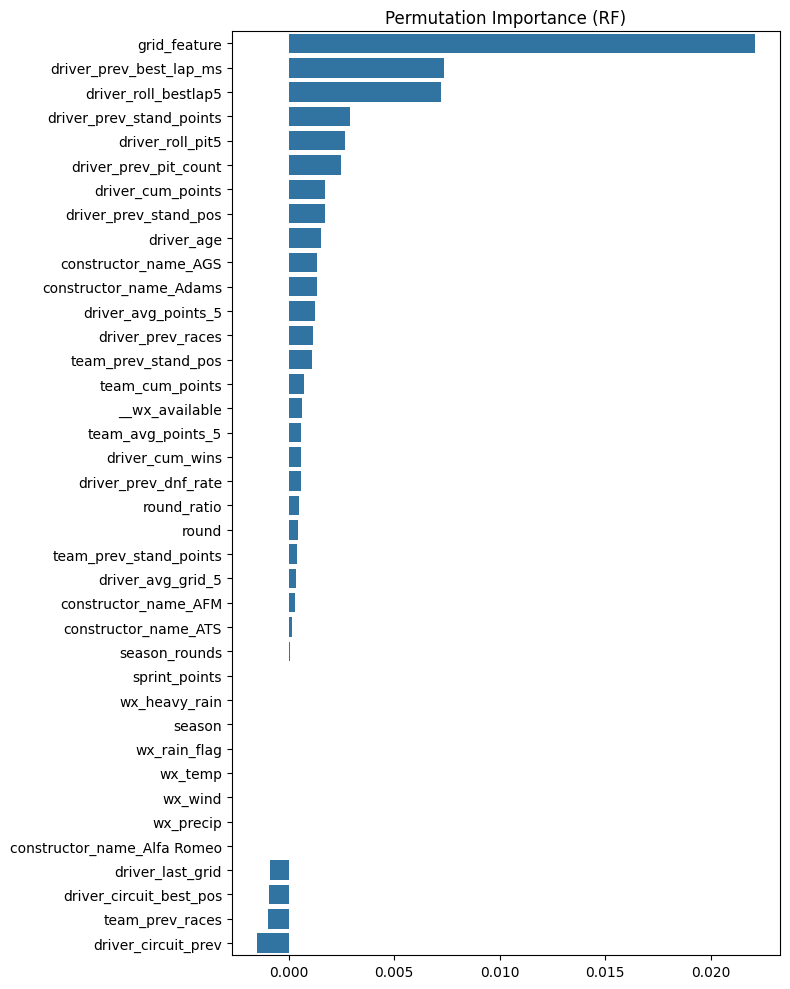

In [25]:
# Importance des features pour RF (approx via permutation sur validation rapide)
from sklearn.inspection import permutation_importance
rf_model = rf
result = permutation_importance(rf_model, X_test, y_test, n_repeats=5, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]
feat_names = num_cols + list(rf_model.named_steps['prep']
    .named_transformers_['cat'].get_feature_names_out(cat_cols_present))
# Attention: l'ordre exact dépendra de ColumnTransformer; ici on approxime en concaténant manuellement.
plt.figure(figsize=(8,10))
sns.barplot(x=result.importances_mean[sorted_idx], y=np.array(feat_names)[sorted_idx])
plt.title('Permutation Importance (RF)')
plt.tight_layout()
plt.show()

## 🌐 Interface Web de simulation (français)

Cette application Streamlit permet de simuler la probabilité de marquer des points pour un pilote donné, avec des réglages simples et lisibles.

Contrôles disponibles (barre latérale) :
- Saison (année)
- Circuit (optionnel)
- Grand Prix
- Écurie (team)
- Voiture n° (optionnel)
- Pilote

Ajustements (facultatif) :
- Position de départ (entier)
- Points du sprint
- Météo simplifiée:
  - Température (°C), Humidité (%), Vent, Précipitations (mm)
  - Pluie ? / Forte pluie ? (Oui / Non)

Affichage des résultats :
- Probabilité (%) et jauge visuelle
- Prédiction Oui/Non (seuil 50%)
- Contexte (circuit, écurie, n° de voiture)

Exécution locale:
1. Entraînez/sauvegardez le modèle depuis ce notebook (cellules d’entraînement + sauvegarde).
2. Lancez le serveur web depuis la racine du projet.
3. Ouvrez la page locale dans votre navigateur.

Conseils:
- La « Position de départ » correspond à la meilleure position de qualification si disponible.
- Les entrées météo peuvent être laissées par défaut si vous n’avez pas d’information précise.


## 🏎️ Mode « Simulation (bêta) » dans l’application Web

Nous avons ajouté un troisième mode au simulateur Streamlit : « Simulation (bêta) ».
Ce mode exécute une simulation Monte Carlo des résultats du Grand Prix à partir du modèle de probabilité de marquer des points, en ajoutant de l’aléa, l’effet de la position sur la grille, des DNF et des incidents.

- Paramètres principaux:
  - Itérations: nombre d’itérations Monte Carlo (par défaut 1000)
  - Variabilité (écart-type): intensité du bruit aléatoire ajouté au score de performance
  - Influence position de départ: poids de la grille (pole ≈ avantage)
  - Multiplicateur DNF: facteur appliqué à la probabilité historique de DNF par pilote
  - Taux d’incidents (%): fréquence d’incidents aléatoires par pilote/itération
  - Sévérité incidents: impact négatif moyen d’un incident sur la performance
  - Graine aléatoire: pour reproduire les résultats

- Logique (simplifiée):
  1. On convertit la probabilité de points du modèle en « logit » (score de base).
  2. On ajoute un bruit gaussien contrôlé par « Variabilité ».
  3. On ajoute un bonus proportionnel à la position de départ (paramètre « Influence position de départ »).
  4. On tire des incidents (fréquence et sévérité) qui dégradent le score.
  5. On tire des DNF selon l’historique du pilote (multiplié par le facteur DNF) et on place ces cas en fin de classement.
  6. On ordonne les pilotes par score pour obtenir un classement simulé à chaque itération.
  7. On calcule des agrégats: proba de victoire/podium/points, rang médian/moyen, DNF%, points attendus.

- Sorties:
  - Tableau résumé trié par rang médian: Proba victoire/podium/points, DNF%, rangs, points attendus.
  - Focus pilote: histogramme des rangs simulés et métriques clés du pilote sélectionné.

Remarques:
- Il s’agit d’un prototype heuristique. Pour un classement encore plus réaliste, on peut entraîner un modèle dédié de position finale (ordinal/Plackett–Luce) ou enrichir la simulation (safety car, stratégies d’arrêts, dégradation pneus, météo dynamique, corrélations).